In [217]:
from imp import reload
import gensim
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib as mpl
import nltk,re,pprint
import sys,glob,os
import operator, string, argparse, math
import matplotlib.pyplot as plt

# class to read and preprocess data
class dataProcessor:
    def __init__(self, fname, keepFactors):
        #keep_factors = ['Job Description', 'Company Name', 'Industry']
        self.dataInitial = pd.read_csv(fname, encoding="latin")
        if keepFactors:
            self.dataInitialSmall = self.dataInitial[['Job Description', 'Company Name', 'Industry']]
        else:
            self.dataInitialSmall = None

    # pipeline for purifying the text, write-pipeline, so just output filename can be provided
    def rem_stop_punct(self,originalText, ofilename):
        splittedText = originalText.split()
        lenl = len(splittedText)
        #print("Length is: ",lenl, splittedText[:5])
        ofile = open(ofilename,'a')
        
        for r in range(lenl):
            linex = splittedText[r]
            linex2 = "".join(c for c in linex if c not in ('!','.',':',',','?',';','``','&','-','"','(',')','[',']','0','1','2','3','4','5','6','7','8','9'))
            linex3 = linex2.split()
            #prog=(r+1)/len(rawlines)
            for s in range(len(linex3)):
                noword = linex3[s].lower()
                if noword not in self.swords:
                    ofile.write(noword)
                    ofile.write(" ")

# primary tf-idf class
class flingTFIDF:
    def __init__(self,data,cname):
        self.idfMatrix = {}
        self.distanceMatrix = {}
        self.termsforIDF = []
        self.cname = cname
        self.data = data
        self.lenv = len(self.data)
        self.swords = set(stopwords.words('english'))

    def drawProgressBar(self,percent, barLen = 50):			#just a progress bar so that you dont lose patience
        sys.stdout.write("\r")
        progress = ""
        for i in range(barLen):
            if i<int(barLen * percent):
                progress += "="
            else:
                progress += " "
        sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
        sys.stdout.flush()

    def rem_stop_punct(self,originalText):
        splittedText = originalText.split()
        lenl = len(splittedText)
        wordFiltered = []
        tSent = []
        for r in range(lenl):
            wordx_1 = splittedText[r]
            wordx_2 = "".join(c for c in wordx_1 if c not in ('!','.',':',',','?',';','``','&','-','"','(',')','[',']','0','1','2','3','4','5','6','7','8','9')) 
            sWord = wordx_2.lower()
            if sWord not in self.swords:
                tSent.append(sWord)
        return " ".join(tSent)
        
    def smartTokenizeColumn(self):
        self.stopsRemoved = []
        for index, row in self.data.iterrows():
            prog=(index+1)/self.lenv
            originText = row[self.cname]
            sentx = self.rem_stop_punct(originText)
            self.drawProgressBar(prog)
            self.data.loc[index,'stopsRemoved'] = sentx
        self.cname = 'stopsRemoved'
        
    def getTF(self):
        print("\nAdding term frequency column based on",self.cname)
        tfMatrixList = []
        for index, row in self.data.iterrows():
            words_in_column = row[self.cname].split()
            if len(words_in_column)!=0:
                counts_all = Counter(words_in_column)
                words, count_values = zip(*counts_all.items())
                values_sorted, words_sorted = zip(*sorted(zip(count_values, words), key=operator.itemgetter(0), reverse=True))
                tfMatrixList.append(pd.DataFrame({'word': words_sorted, 'tf': values_sorted}))
                #self.data.loc[index,'tfMatrix'] = countdf
            else:
                #self.data.loc[index,'tfMatrix'] = pd.DataFrame(columns = ['word','tf'])
                tfMatrixList.append(pd.DataFrame(columns = ['word','tf']))
            prog=(index+1)/self.lenv
            self.drawProgressBar(prog)
        self.data['tfMatrix'] = tfMatrixList
        
    def getTFIDF(self):
        print("\nComputing and adding TF-IDF column based on",self.cname)
        for index, row in self.data.iterrows():
            tfmatrixThisrow = row['tfMatrix']
            tempTFIDF = []
            for indx, rwx in tfmatrixThisrow.iterrows():
                trmx = rwx['word']
                tfx = rwx['tf']
                idfx = self.idfMatrix[trmx]
                tfidfx = tfx*idfx
                tempTFIDF.append(tfidfx)
                #tfmatrixThisrow.loc[index,'tf-idf'] = tfidfx
            tfmatrixThisrow['tf-idf'] = tempTFIDF
            #sumtfidf = tfmatrixThisrow['tf-idf'].sum() 
            prog=(index+1)/self.lenv
            self.drawProgressBar(prog)
                
    def computeIDFlistofterms(self):
        totalwords = 0
        print("\nComputing list of words for IDF...\n")
        for index, row in self.data.iterrows():
            words_in_column = set(row[self.cname].split())  
            for word in words_in_column:
                if word not in self.termsforIDF:
                    self.termsforIDF.append(word)
                    totalwords+=1
        print("Created list of terms for IDF matrix with", totalwords," terms.")     
        
    def getIdf(self,term):
        countPresentDocs = 0
        lenidf = len(self.termsforIDF)
        for i in range(lenidf):
            tfx = self.getTermFreq(i,term)
            if tfx>0:
                countPresentDocs+=1
            prog=(i+1)/lenidf
            self.drawProgressBar(prog)
        return countPresentDocs
        
    def computeIDFmatrix(self):
        self.computeIDFlistofterms()
        print("\nComputing global IDF matrix...\n")
        for term in self.termsforIDF:
            self.idfMatrix[term]=0
        for index, row in self.data.iterrows():
            listofterms = list(self.data['tfMatrix'][index]['word'])
            for term in listofterms:
                self.idfMatrix[term]=self.idfMatrix[term]+1
            prog=(index+1)/self.lenv
            self.drawProgressBar(prog)
        for term in self.termsforIDF:
            idfx = self.idfMatrix[term]          
            idfy = self.lenv/float(1+idfx)
            idfz = math.log(idfy,10)
            self.idfMatrix[term] = idfz
            
    def showData(self):
        print(self.data['tfMatrix'])
        
    def createDistanceMetadata(self):
        #sumList = []
        for index, row in self.data.iterrows():
            tfmatrixThisrow = row['tfMatrix']
            sumTFIDF = tfmatrixThisrow['tf-idf'].sum()
            #sumList.append({'sumTFIDF':sumTFIDF})
            self.data.loc[index,'sumTFIDF'] = sumTFIDF
            prog=(index+1)/self.lenv
            self.drawProgressBar(prog)
              
    def distanceBtnTwoDocs(self, docId_1, docId_2):
        listWords_1 = set(list(self.data['tfMatrix'][docId_1]['word']))
        listWords_2 = set(list(self.data['tfMatrix'][docId_2]['word']))
        common = listWords_1.intersection(listWords_2)
        diff1_2 = listWords_1.difference(listWords_2)
        diff2_1 = listWords_2.difference(listWords_1)
        sumwt1 = self.data['sumTFIDF'][docId_1]
        sumwt2 = self.data['sumTFIDF'][docId_2]
        score_common, score_doc1, score_doc2 = 0,0,0
        for word_c in common:
            score_1 = float(self.data['tfMatrix'][docId_1].loc[self.data['tfMatrix'][docId_1]['word'] == word_c]['tf-idf'])
            score_2 = float(self.data['tfMatrix'][docId_2].loc[self.data['tfMatrix'][docId_2]['word'] == word_c]['tf-idf'])
            score_common += abs(score_1/float(sumwt1) - score_2/float(sumwt2))
        for word_d12 in diff1_2:
            score_1 = float(self.data['tfMatrix'][docId_1].loc[self.data['tfMatrix'][docId_1]['word'] == word_d12]['tf-idf'])
            score_doc1 += score_1/float(sumwt1)
        for word_d21 in diff2_1:
            score_2 = float(self.data['tfMatrix'][docId_2].loc[self.data['tfMatrix'][docId_2]['word'] == word_d21]['tf-idf'])
            score_doc2 += score_2/float(sumwt2)
        score_total = score_common + score_doc1 + score_doc2
        return(score_total)
    
    def computeDistanceBtnAllDocs(self):
        for j in range(100):
            for k in range(10):
                numx = j*10+k
                dist = self.distanceBtnTwoDocs(j,k)
                self.distanceMatrix[(j,k)] = dist
                prog=(numx+1)/1000
                self.drawProgressBar(prog)
                
        print(self.distanceMatrix[:10])
    
    def writeToFile(self,fname):
        self.data.to_csv(fname)

In [303]:
import matplotlib as mpl
from imp import reload
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk,re,pprint
import sys,glob,os
import operator, string, argparse, math, random, statistics
import matplotlib.pyplot as plt
from sklearn import metrics

class flingPretrained:
    '''
    Trains linguistic models: doc2vec, fastText, word2vec, SDAE
    Load pretrained linguistic models: doc2vec, fastText, word2vec, SDAE
    Save group characteristics
    
    All embeddings available/level/word-order-preserval:
        Glove : word / No
        Doc2Vec : document / Yes
        Word2Vec : word / No
        TF-IDF : document / No
        tfIDF weighted GloVe / No
    '''
    def __init__(self,data):
        self.data = data
        self.nDocs = len(self.data)
        self.nDocsTest = 0
        self.allDistances = {}
        self.groupedCharacteristic = {'glove' : None, 'vec_tfidf-doc2vec' : None, 'vec_tfidf-glove' : None, 'doc2vec' : None}
        self.wordVecModel = {'glove':None, 'doc2vec':None}
        print("\nWorking on pretrained word embeddings!\n")
        
    '''
    Load pretrained word vectors: gloVe, fastText, doc2vec, word2vec, SDAE
    by calling the appropriate load function for the vector type.
    '''
    def loadPretrainedWordVectors(self,vecType):
        if vecType == 'glove':
            self.wordVecModel['glove'] = self.loadGloveModel()
            print("GloVe Vectors Loaded!\n") 

    '''
    Loads the glove model provided a filename.
    TASK: edit the function to take a filename instead of hard-coding the location of the GloVe model.
    '''
    def loadGloveModel(self):
        print("Loading Glove Model\n")
        try:
            f = open('../datasets/glove.6B/glove.6B.50d.txt','r')
        except:
            f = open('datasets/glove.6B/glove.6B.50d.txt','r')
        gloveModel = {}
        for line in f:
            splitLines = line.split()
            word = splitLines[0]
            wordEmbedding = np.array([float(value) for value in splitLines[1:]])
            gloveModel[word] = wordEmbedding
        print(len(gloveModel)," words loaded!\n")
        return(gloveModel)
    
    '''
    Returns the computed GloVe vector for the document. Note: a document contains multiple words, 
    and we have word vectors corresponding to every word in Glove
    '''
    def getDocVector(self,doc_Id):
        gvl=self.getGloveVectorList(listx)
        glove_dv = np.mean(gvl,axis=0)
        return(glove_dv)
    
    '''
    Returns a list of GloVe vectors for all words in the document.
    '''
    def getGloveVectorList(self,listx):
        vecList = []
        nf = []
        presenceBit = []
        for w in listx:
            try:
                vecList.append(self.wordVecModel['glove'][w])
                presenceBit.append(1)
            except:
                presenceBit.append(0)
                nf.append(w)
                continue        
        if len(vecList)==0:
            return([[0]*50],[])
        vecArray = np.stack(vecList, axis=0)
        return vecArray,presenceBit  
    
    '''
    Add two new computed vectors to the data.
        a) glove-vector : plain GloVe vectors non-weighted
        b) glove-tfidf : GloVe vectors weighted with their tfIDF scores 
    uses numpy.average(a, axis=None, weights=None, returned=False)[source]
    '''
    def addDocumentGloveVectors(self):
        vecL = []
        vecWL = []
        for indx in range(self.nDocs):
            listWords_1 = set(list(self.data['tfMatrix'][int(indx)]['word']))
            tFreqs = np.asarray(list(self.data['tfMatrix'][int(indx)]['tf']))
            gvl,prBit = self.getGloveVectorList(listWords_1)
            if prBit == []:
                vecL.append([0]*50)
                vecWL.append([0]*50)         
                continue;
            termFreqs = [a*b for (a,b) in zip(prBit,tFreqs) if a*b!=0]            #print("listWords1,termFreqs",listWords_1,termFreqs)
            vecL.append(np.nanmean(gvl,axis=0))
            vecWL.append(np.average(gvl, axis=0, weights=termFreqs))          
        self.data['glove-vector'] = vecL
        self.getDistanceDistribution(100,'glove-vector')
        self.data['glove-tfIDF'] = vecWL
        self.getDistanceDistribution(100,'glove-tfIDF')
        
    '''
    Distance between two documents using TF-IDF dictionaries.
        Method used: Using 'percentage of importance' by using tf-idf score as weights
    '''
    def distanceBtnTwoDocs(self, docId_1, docId_2):
        listWords_1 = set(list(self.data['tfMatrix'][int(docId_1)]['word']))
        listWords_2 = set(list(self.data['tfMatrix'][int(docId_2)]['word']))
        common = listWords_1.intersection(listWords_2)
        diff1_2 = listWords_1.difference(listWords_2)
        diff2_1 = listWords_2.difference(listWords_1)
        sumwt1 = self.data['sumTFIDF'][docId_1]
        sumwt2 = self.data['sumTFIDF'][docId_2]
        score_common, score_doc1, score_doc2 = 0,0,0
        #print(len(common),len(diff1_2),len(diff2_1))
        for word_c in common:
            score_1 = float(self.data['tfMatrix'][docId_1].loc[self.data['tfMatrix'][docId_1]['word'] == word_c]['tf-idf'])
            score_2 = float(self.data['tfMatrix'][docId_2].loc[self.data['tfMatrix'][docId_2]['word'] == word_c]['tf-idf'])
            score_common += abs(score_1/float(sumwt1) - score_2/float(sumwt2))
        for word_d12 in diff1_2:
            score_1 = float(self.data['tfMatrix'][docId_1].loc[self.data['tfMatrix'][docId_1]['word'] == word_d12]['tf-idf'])
            score_doc1 += score_1/float(sumwt1)
        for word_d21 in diff2_1:
            score_2 = float(self.data['tfMatrix'][docId_2].loc[self.data['tfMatrix'][docId_2]['word'] == word_d21]['tf-idf'])
            score_doc2 += score_2/float(sumwt2)
        score_total = score_common + score_doc1 + score_doc2
        return(score_total)
    
    #document vector is the average of all the word vectors gloVe
    def getDocVector(self,listx):
        gvl=self.getGloveVectorList(listx)
        glove_dv = np.mean(gvl,axis=0)
        return(glove_dv)
    
    '''
    Returns the distance between two GloVe vectors.
    '''
    def getGloveDistance(self,docId_1,docId_2,method):
        listWords_1 = set(list(self.data['tfMatrix'].iloc[int(docId_1)]['word']))
        listWords_2 = set(list(self.data['tfMatrix'].iloc[int(docId_2)]['word']))
        if method == 'average':
            dv_1 = self.getDocVector(listWords_1)
            dv_2 = self.getDocVector(listWords_2)
            dist = np.linalg.norm(dv_1-dv_2)
            return dist
              
    def drawProgressBar(self, percent, barLen = 50):			#just a progress bar so that you dont lose patience
        sys.stdout.write("\r")
        progress = ""
        for i in range(barLen):
            if i<int(barLen * percent):
                progress += "="
            else:
                progress += " "
        sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
        sys.stdout.flush()
        
    def getDistance(self,docId_1,docId_2,vectorName):
        if method == 'glove':
            dv_1 = self.data['glove-vector'][int(docId_1)]
            dv_2 = self.data['glove-vector'][int(docId_2)]
        elif method == 'tfidf':
            dv_1 = self.data['tfidf2vec-tfidf'][int(docId_1)]
            dv_2 = self.data['tfidf2vec-tfidf'][int(docId_2)]           
        dist = np.linalg.norm(dv_1-dv_2)
        return dist

    '''
    Get sample distance distribution between numx random documents in the data and plot histogram 
    '''
    def getDistanceDistribution(self,numx,vectorName):
        numHalf = int(numx/2)
        doca,docb = [],[]
        for i in range(numHalf):
            doca.append(random.randint(1,1026))
            docb.append(random.randint(1027,2053))
        distanceSample = []
        total = numHalf*numHalf
        for doc_1 in range(len(doca)):
            for doc_2 in range(len(docb)):
                dv_1 = self.data[vectorName][int(doc_1)]
                dv_2 = self.data[vectorName][int(doc_2)]           
                dist = np.linalg.norm(dv_1-dv_2)
                distanceSample.append(dist)
                cov = doc_1*numHalf + doc_2
                prog=(cov+1)/total
                self.drawProgressBar(prog)
        pltx = plt.hist(distanceSample,bins=50)
        return(pltx)
    
    '''
    Returns the gloVe vector for the word from the pre-trained gloVe vectors.
    '''
    def getGloveScore(self,w):
        try:
            return(self.wordVecModel['glove'][w])
        except:
            return([0*50]) 
    
    '''
    Combines document tfIDF dictionary with other document vectors to create combined vectors. 
    '''
    def doctfidf2vec(self,docId,mode):
        docVecList = []
        listWords = list(self.data['tfMatrix'][int(docId)]['word'])
        if mode == "tf-only":
            scores = list(self.data['tfMatrix'][int(docId)]['tf'])
        elif mode == "tf-idf":
            scores = list(self.data['tfMatrix'][int(docId)]['tf-idf'])
        lenW =len(listWords)
        gloveScores = [self.getGloveScore(el) for el in listWords]
        for j in range(lenW):
            temp = [float(scores[j])]*50
            #gloveScores[j]
            res = [a*b for (a,b) in zip(temp,gloveScores[j])]
            if len(res)==1:
                continue;
            else:
                docVecList.append(res)            
        return(np.nanmean(docVecList,axis=0))
    
    '''
    For each group in the specified column, average all the document vectors in the 
    group to create a group characteristic
    
    TASK: explore more options of averaging the vectors. '''
    def createGroupedCharacteristics(self,column):
        vecList = ['glove-vector','doc2vec','vec_tfidf-glove','glove-tfIDF']
        self.dataTrain.groupby([column])
        print("\nComputing groupCharacteristics for,",column)
        for vec in vecList:
            self.groupedCharacteristic[vec] = self.dataTrain.groupby(column)[vec].apply(np.average).to_frame()
 
    '''
    Function to return the group most simimar to the vector, based on distance computed with every group characteristics.
    '''
    def getNearestGroup(self,vec,vectorName):
        minDist = math.inf
        minGroup = None
        for colx in fdb.groupedCharacteristic[vectorName].index.values:
            vecy = fdb.groupedCharacteristic[vectorName].loc[colx].to_numpy(dtype=object)
            if not np.all(vec):
                vec = ([0.0001]*50)
            distx = np.linalg.norm(scipy.spatial.distance.cosine(vec,vecy))
            if distx < minDist:
                minDist = distx
                minGroup = colx                 
        return minGroup
    
    '''
    Explore options to optimize space using function.
    '''
    def splitTestTrain(self):
        mPt = int(self.nDocs*0.7)
        self.dataTrain = self.data[:mPt]
        self.dataTest = self.data[mPt:]
        self.nDocsTest = len(self.dataTest)
               
    '''
    Add computed group as a new column.
    '''
    def addVectorComputedGroup(self,vectorName,groupName):
        computedGroups = []
        for docId in range(self.nDocsTest):
            computedGroup = self.getNearestGroup(self.dataTest[vectorName].iloc[docId],vectorName)
            computedGroups.append(computedGroup)           
        self.dataTest[groupName] = computedGroups      
    '''
    Simple percentage count of documents which got the correct labels assigned.
    '''  
    def getAccuracy(self,compareWith,vecName):
        countCorrect = 0
        for d in range(self.nDocsTest):
            if self.dataTest[vecName].iloc[d] == self.dataTest[compareWith].iloc[d]:
                countCorrect+=1
        print("Accuracy of",vecName,countCorrect/self.nDocsTest*100,"%")

    '''
    Convert tfIDF dictionary for every document with precomputed word-embeddings
    '''
    def tfidf2vec(self,mode,method):
        vecL = []
        if mode == 'tf-only':
            columnName = 'vec_tf-' + method
            print("\nComputing column:",columnName)
            for indx in range(self.nDocs):
                gvl=self.doctfidf2vec(indx,'tf-only')
                vecL.append(gvl)
                prog=(indx+1)/self.nDocs
                self.drawProgressBar(prog)
        else:
            columnName = 'vec_tfidf-' + method
            print("\nComputing column:",columnName)
            for indx in range(self.nDocs):
                gvl=self.doctfidf2vec(indx,'tf-idf')
                vecL.append(gvl)
                prog=(indx+1)/self.nDocs
                self.drawProgressBar(prog)
        self.data[columnName] = vecL
        try:
            self.getDistanceDistribution(100,'glove-tfIDF')
        except:
            return

class vectorize:
    def __init__(self,data,factorName):
        self.data = data
        self.dataNew = []
        self.model = None
        self.swords = set(stopwords.words('english'))
        self.factorName = factorName
        for docId in range(len(self.data)):
            dv_1 = self.data[factorName][int(docId)]
            self.dataNew.append(dv_1)
        self.nDocs = len(self.dataNew)
        print(self.nDocs,"documents added!")
        
    '''
    Tokenizer: Remove stopwords and punctuations.
    TASK: Add standard available tokenizers.
    '''
    def rem_stop_punct(self,originalText):
        splittedText = originalText.split()
        lenl = len(splittedText)
        wordFiltered = []
        tSent = []
        for r in range(lenl):
            wordx_1 = splittedText[r]
            wordx_2 = "".join(c for c in wordx_1 if c not in ('!','.',':',',','?',';','``','&','-','"','(',')','[',']','0','1','2','3','4','5','6','7','8','9')) 
            sWord = wordx_2.lower()
            if sWord not in self.swords:
                tSent.append(sWord)
        return tSent

    def tagged_document(self,list_of_list_of_words):
        for i, list_of_words in enumerate(list_of_list_of_words):
            yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

    '''
    Train doc2vec vectors on the training dataset.
    '''
    def trainDocVectors(self):
        print("\nTraining doc2vec model.")
        self.data_for_training = list(self.tagged_document(self.dataNew))
        self.model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=30)
        self.model.build_vocab(self.data_for_training)
        self.model.train(self.data_for_training, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        #self.model.to_pickle("model_doc2vec.pkl")
        return(self.model)
        
    def addDocVectors(self):
        print("\nAdding doc2vec vectors to dataset.")
        docVectors = []
        for docId in range(len(self.data)):
            docVectors.append(self.model.infer_vector(self.rem_stop_punct(self.data[self.factorName][int(docId)])))
        self.data['doc2vec'] = docVectors
        
class flingDBSCAN:
    def __init__(self,data,epsilon,minPts,method):
        self.data = data
        self.method = method
        self.minPts = minPts
        self.noisePts = []
        self.nDocs = len(self.data)
        self.clusterCharacteristic = None 
        self.clusterIndex = 0 
        self.clusterCount = 0 
        self.clusterLabel = "computedCluster"
        print("\nflingDBSCAN initialized!\n")
        self.clusterMetadata = {}
        for i in range(self.nDocs):
            self.clusterMetadata[i] = None
        if epsilon:
            self.epsilon = epsilon
        else:
            if method == 'glove':
                self.epsilon = self.getBestDistance('glove')
                print("\nBest epsilon computed on GLOVE =",self.epsilon,"\n")
            else:
                self.epsilon = self.getBestDistance('tfidf')
                print("\nBest epsilon computed on GLOVE-TFIDF =",self.epsilon,"\n")
            
    def getBestDistance(self,method):
        numx = 100
        numHalf = int(numx/2)
        doca,docb = [],[]
        print("computing best distance")
        for i in range(numHalf):
            doca.append(random.randint(1,int(self.nDocs/2)))
            docb.append(random.randint(int(self.nDocs/2)+1,self.nDocs))
        distanceSample = []
        total = numHalf*numHalf
        for doc_1 in range(len(doca)):
            for doc_2 in range(len(docb)):
                if method == 'glove':
                    distanceSample.append(self.getDistance(doc_1,doc_2,'glove'))
                else:
                    distanceSample.append(self.getDistance(doc_1,doc_2,'tfidf'))
                cov = doc_1*numHalf + doc_2
                prog=(cov+1)/total
                self.drawProgressBar(prog)
        plt.show(plt.hist(distanceSample,bins=20))
        return statistics.mean(distanceSample)
            
    def assignLabel(self,dictDist,label):
        for el in dictDist:
            self.clusterMetadata[el]=label
            
    def printClusterInfo(self):
        print("Cluster characteristics:")
        print(" -- vectors:",self.method)
        print(" -- minPts:",self.minPts)
        print(" -- EstimatedBestDistance",self.epsilon)
        print(" --",self.clusterCount,"clusters formed!")
        print(" --",self.nDocs-len(self.noisePts),"points assigned to clusters!") 
        print(" --",len(self.noisePts),"noise points!\n")
        noisePc = len(self.noisePts)/self.nDocs*100
        print(" --",noisePc,"% noise!\n")
            
    def printClusterMetadata(self,n):
        for j in range(n):
            print(j, self.clusterMetadata[j])
         
    # range query equivalent function
    def findNeighborOf(self,ptIndex,method):
        distance = {}      
        #first vector
        if method == 'glove':
            dv_1 = self.data['glove-vector'][int(ptIndex)] 
        elif method == 'tfidf':
            dv_1 = self.data['tfidf2vec-tfidf'][int(ptIndex)]
        
        #iterating over the whole data for the second vector 
        if method == 'tfidf':
            for j in range(self.nDocs):
                dv_2 = self.data['tfidf2vec-tfidf'][j]
                if j!=ptIndex:
                    distx = self.getDistance(ptIndex,j,'tfidf')
                    distance[j] = distx
        elif method == 'glove':
            for j in range(self.nDocs):
                dv_2 = self.data['glove-vector'][j]
                if j!=ptIndex:
                    distx = self.getDistance(ptIndex,j,'glove')
                    distance[j] = distx
        
        # keeping only elements at a distnce of less than epsilon
        tempDistances = {key:value for (key,value) in distance.items() if value<self.epsilon}
        newDistances = {key:value for (key,value) in tempDistances.items() if self.clusterMetadata[key]==None}
        # keeping the cluster only if we 
        if len(newDistances)>self.minPts:    
            return newDistances.keys()
        else:
            return None
            
    def dbscanCompute(self):
        print("\ninitiating DBSCAN Clustering with",self.method,"vectors\n")
        self.clusterMetadata[0]='cluster_0_'
        for k in range(self.nDocs):
            if not self.clusterMetadata[k]:
                if self.method=='glove':
                    neighbors = self.findNeighborOf(k,'glove')
                else:
                    neighbors = self.findNeighborOf(k,'tfidf')
                if neighbors:
                    self.clusterCount+=1
                    clusterName = "cluster_" + str(self.clusterCount)+"_"
                    self.clusterMetadata[k] = clusterName
                    
                    # neighboring points of original point
                    for nbPoint in neighbors:
                        if not self.clusterMetadata[nbPoint]:
                            self.clusterMetadata[nbPoint] = clusterName
                    if self.method=='glove':
                        innerNeighbors = self.findNeighborOf(k,'glove')
                    else:
                        innerNeighbors = self.findNeighborOf(k,'tfidf')
                    if innerNeighbors:
                        for nb in innerNeighbors:
                            self.clusterMetadata[nb] = clusterName
                            neighbors.append(nb)                          
                    print("\n ---- ",clusterName,"assigned to",len(neighbors),"points! ----")
                else:
                    self.noisePts.append(k)
            prog=(k+1)/self.nDocs
            self.drawProgressBar(prog)
        print("\n",self.clusterCount,"clusters formed!")

    ''' 
    Get distance between two vectors based on method. Only single vector methods available. Combined methods yet to add.
    '''
    def getDistance(self,docId_1,docId_2,method):
        if method == 'glove':
            dv_1 = self.data['glove-vector'][int(docId_1)]
            dv_2 = self.data['glove-vector'][int(docId_2)]
        elif method == 'tfidf':
            dv_1 = self.data['tfidf2vec-tfidf'][int(docId_1)]
            dv_2 = self.data['tfidf2vec-tfidf'][int(docId_2)]           
        dist = np.linalg.norm(dv_1-dv_2)
        return dist
    
    def addClusterLabel(self,label):
        self.clusterLabel = label
        vec = []
        for el in self.clusterMetadata.keys():
            vec.append(self.clusterMetadata[el])
        self.data[label] = vec
        
    def getNearestGroup(self,vec):
        minDist = 100
        minGroup = None
        for colx in fdb.groupedCharacteristic.columns:
            vecy = fdb.groupedCharacteristic[colx]['glove-vector']
            distx = np.linalg.norm(vec-vecy)
            if distx<minDist:
                minDist = distx
                minGroup = colx
        return minGroup
    
    def addClusterMajorityLabel(self):
        clusterMap = {}
        for docId in range(self.nDocs):
            computedGroup = self.getNearestGroup(self.data['glove-vector'][int(docId)])
            clID = self.data['glove-vector'][int(docId)]
            if clID not in self.clusterCharacteristic:
                self.clusterCharacteristic[clID]=[computedGroup]
            else:
                self.clusterCharacteristic[clID].append(computedGroup)
            prog=(docId+1)/self.nDocs
            self.drawProgressBar(prog)
        for k in self.clusterCharacteristic.key():
            res = statistics.mode(self.clusterCharacteristic[k])
            clusterMap[k] = res
        return(clusterMap)

    def addVectorComputedGroup(self,vecName,factorName):
        computedGroups = []
        for docId in range(self.nDocs):
            computedGroup = self.getNearestGroup(self.data[vecName][int(docId)])
            computedGroups.append(computedGroup)
        self.data[factorName] = computedGroups
              
    def getAccuracy(self,compareWith):
        countCorrect = 0
        for d in range(self.nDocs):
            if self.data['characteristicGroup'][d] == self.data[compareWith][d]:
                countCorrect+=1
        print("Accuracy:",countCorrect/self.nDocs*100,"%")
        
    def evaluateClusterPerformance(self,compareWith):
        return(metrics.adjusted_rand_score(self.data['characteristicGroup'],self.data[compareWith]))
    
    '''
    TASK: optimize the progressbar.
    '''
    def drawProgressBar(self, percent, barLen = 50):			#just a progress bar so that you dont lose patience
        sys.stdout.write("\r")
        progress = ""
        for i in range(barLen):
            if i<int(barLen * percent):
                progress += "="
            else:
                progress += " "
        sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
        sys.stdout.flush()	

In [37]:
#from fling import utilities as ut
#from fling import tfidfModule as tfm
os.chdir("/Users/arnabborah/Documents/repositories/fling/")
spamtm = dataProcessor("datasets/spamTextMessages.csv",None)

In [38]:
# primary distance module run
ftf = flingTFIDF(spamtm.dataInitial,'Message')

In [39]:
ftf.smartTokenizeColumn()
ftf.getTF()
ftf.computeIDFmatrix()
ftf.getTFIDF()
ftf.createDistanceMetadata()

[ ================================================== ] 100.00%
Adding term frequency column based on stopsRemoved
[ ================================================== ] 100.00%
Computing list of words for IDF...

Created list of terms for IDF matrix with 8780  terms.

Computing global IDF matrix...

[ ================================================== ] 100.00%
Computing and adding TF-IDF column based on stopsRemoved
[ ================================================== ] 100.00%

In [155]:
import gensim

#training and adding doc2vec vectors based on column 'Messages'
vecc = vectorize(ftf.data,'Message')
trained_doc2vec_model = vecc.trainDocVectors()
vecc.addDocVectors

5572 documents added!

Training doc2vec model.

Adding doc2vec vectors to dataset.



Working on pretrained word embeddings!

Loading Glove Model

400000  words loaded!

GloVe Vectors Loaded!

[ ================================================== ] 100.00%
Computing column: vec_tfidf-glove
[ ==                                                 ] 5.65%

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:237: RuntimeWarning: Mean of empty slice


[ ================================================== ] 100.00%[ ============================================       ] 88.00%
Computing groupCharacteristics for, Category


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy of cGroup_glove 79.84449760765551 %
Accuracy of cGroup_doc2vec 56.10047846889952 %
Accuracy of cGroup_gloveWt_tfidf 79.72488038277513 %
Accuracy of cGroup_tfidf-glove 0.0 %


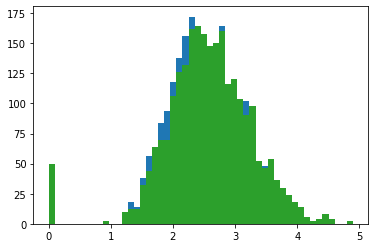

In [304]:
# adding pretrained and combined vectors and vector computed group
import gensim 
import tfidfModule as tfm

#dataProcessed = pd.read_pickle('datasets/data_tfidf_processed.pkl')
fdb = tfm.flingPretrained(ftf.data)
#adding pretrained glove vectors 
fdb.loadPretrainedWordVectors('glove')
fdb.addDocumentGloveVectors()

#adding combo vectors with tfidf and (glove + doc2vec) for inter sentence semantic information addition
fdb.tfidf2vec('tf-idf','glove')
#fdb.tfidf2vec('tf-idf','doc2vec')
fdb.splitTestTrain()

# train group characteristics on column 'category' and predict vector based category, and compute error
fdb.createGroupedCharacteristics('Category')
fdb.addVectorComputedGroup('glove-vector','cGroup_glove')
fdb.addVectorComputedGroup('doc2vec','cGroup_doc2vec')
fdb.addVectorComputedGroup('glove-tfIDF','cGroup_gloveWt_tfidf')
fdb.addVectorComputedGroup('vec_tfidf-glove','cGroup_tfidf-glove')

#fdb.addVectorComputedGroup('vec_tfidf-doc2vec','cGroup_tfidf-doc2vec')
fdb.getAccuracy('Category','cGroup_glove')
fdb.getAccuracy('Category','cGroup_doc2vec')
fdb.getAccuracy('Category','cGroup_gloveWt_tfidf')
fdb.getAccuracy('Category','cGroup_tfidf-glove')

In [232]:
fdb.data

,Category,Message,stopsRemoved,tfMatrix,sumTFIDF,glove-vector,doc2vec,vec_tfidf-glove,glove-tfIDF
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,word tf tf-idf 0 go 1 ...,38.281443,"[0.21390625000000005, 0.3857445625, -0.1334233...","[0.023361368, -0.01737977, -0.015450012, 0.030...","[0.5959587370342363, 0.8768489600169621, -0.51...","[0.21390625000000005, 0.3857445625, -0.1334233..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,word tf tf-idf 0 ok 1 1.31950...,12.583182,"[-0.34427266666666667, -0.11794016666666667, 0...","[0.01824778, -0.032706685, -0.040531408, 0.051...","[-0.6469232570438529, -0.4567087086249299, -0....","[-0.34427266666666667, -0.11794016666666667, 0..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st...,word tf tf-idf 0 entry ...,49.524838,"[-0.3973114285714286, 0.43085399999999996, -0....","[0.0028259559, 0.0051632347, 0.0085555585, 0.0...","[-1.3248417366882783, 1.1032396880662387, -0.5...","[-0.38814812499999995, 0.482244125, -0.0930190..."
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,word tf tf-idf 0 u 2 1.669...,16.431526,"[0.17517428571428573, 0.24041571428571432, 0.2...","[-0.00799464, -0.02401544, -0.069796, 0.108990...","[0.5123484443079068, 0.5753741094651186, 0.311...","[0.19404333333333332, 0.1887144444444444, 0.15..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though,word tf tf-idf 0 nah 1 2.70461...,16.678825,"[0.19229857142857143, 0.4842861428571427, 0.19...","[-0.005010659, 0.00058875955, 0.0060600745, -0...","[0.47549546283727345, 1.2971284798171407, 0.48...","[0.19229857142857143, 0.4842861428571427, 0.19..."
...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,nd time tried contact u u â£ pound prize cla...,word tf tf-idf 0 ...,29.685673,"[-0.0032673076923077126, 0.2802763076923076, 0...","[-0.024376733, -0.06455596, -0.054250874, 0.07...","[-0.018272115681935517, 0.38059669250977396, 0...","[-0.0284332142857143, 0.348728, 0.557019499999..."
5568,ham,Will Ã¼ b going to esplanade fr home?,ã¼ b going esplanade fr home,word tf tf-idf 0 ã¼ 1 1...,12.328684,"[0.2450002, 0.433446, -0.009058, -0.1098192, 0...","[0.026062477, -0.083403476, 0.0068779653, 0.02...","[0.7474427145489011, 1.10828246067343, -0.1888...","[0.2450002, 0.433446, -0.009058, -0.1098192, 0..."
5569,ham,"Pity, * was in mood for that. So...any other s...",pity * mood soany suggestions,word tf tf-idf 0 pity ...,15.080331,"[-0.16283274999999997, 0.44291, -0.20726499999...","[0.2500398, 0.048694123, 0.01599926, 0.1155695...","[-0.10259994304988762, 1.0048869796671016, -0....","[-0.16283274999999997, 0.44291, -0.20726499999..."
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like i'd interested buying ...,word tf tf-idf 0 guy ...,32.770129,"[0.1625725923076923, -0.08889784615384616, 0.0...","[0.0029246681, -0.00042458618, 0.0025144704, -...","[0.4332410359621821, -0.43844977348643754, 0.1...","[0.1625725923076923, -0.08889784615384616, 0.0..."


In [301]:
# glove-TFIDF computing nan values as distances
vecList = ['glove-vector','doc2vec','vec_tfidf-glove','glove-tfIDF']
for vec in vecList:
    print(fdb.dataTrain.groupby('Category')[vec].apply(np.average).to_frame())

                                               glove-vector
Category                                                   
ham       [0.08621057522946847, 0.16108873455431685, 0.1...
spam      [0.03802002928660192, 0.25794960063990663, 0.2...
                                                    doc2vec
Category                                                   
ham       [0.004500571, -0.0046128747, -0.0037903993, 0....
spam      [0.007353711, 0.00052847125, -0.0015033685, 0....
                                            vec_tfidf-glove
Category                                                   
ham       [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
spam      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
                                                glove-tfIDF
Category                                                   
ham       [0.08530872151116166, 0.16057492748951366, 0.1...
spam      [0.036856856000276404, 0.2598861828935243, 0.2...
